$\textbf{Name}:$   Willard Ford

$\textbf{Group Number}$: Group 7

# BIPN 164: Homework #1
### Due **04-21-2023 at 8PM**. Please justify all your answers. If you have any questions, please email your TA's Meg Robinson (m5robinson@ucsd.edu) or Chandramouli Rajagopalan (crajagopalan@ucsd.edu)

# Instructions:
**To start working on this Homework, create a copy of this notebook and save it within your Google Drive (File -> Save a copy in Drive).**

This Jupyter notebook contains exercises consisting of coding and discussion questions. For the discussion questions, please write your answer within a new markdown/text cell. Please hand in your .ipynb file (File -> Download -> Download .ipynb) on canvas by **8PM** on **Friday April 21**.

To execute the code, it is necessary to load some external packages, so please execute the following code block.

In [7]:
# IMPORT STATEMENTS
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

To implement the HH model, you will need to implement the equations to model the Sodium, Potassium, and Leak currents:

All the equations necessary to model the Sodium current:

\begin{align}
  I_{Na}   &= \bar{g}_{Na} m^3 h (V-E_{Na})\\
  \alpha_m &= 0.1 \frac{V+40}{1-e^{-\frac{V+40}{10}}} \\
  \beta_m  &= 4 e^{-\frac{V+65}{18}} \\
  \tau_m &= \frac{1}{\alpha_m(V) + \beta_m(V)} \\
  m_0 &= \frac{\alpha_m(V)}{\alpha_m(V) + \beta_m(V)}\\
  \frac{dm}{dt} &= -\frac{1}{\tau_m (V)}[m-m_0(V)] \\
  \alpha_h &= 0.07 e^{-\frac{V+65}{20}} \\
  \beta_h  &= \frac{1}{1+e^{-\frac{V+35}{10}}} \\
  \tau_h &= \frac{1}{\alpha_h(V) + \beta_h(V)} \\
  h_0 &= \frac{\alpha_h(V)}{\alpha_h(V) + \beta_h(V)}\\
  \frac{dh}{dt} &= -\frac{1}{\tau_h (V)}[h-h_0(V)] \\
\end{align}

All the equations necessary to model the Potassium current:
\begin{align}
  I_{K}   &= \bar{g}_{K} n^4 (V-E_{K})\\
  \alpha_n &= 0.01 \frac{V+55}{1-e^{-\frac{V+55}{10}}} \\
  \beta_n  &= 0.125 e^{-\frac{V+65}{80}}\\
  \tau_n &= \frac{1}{\alpha_n(V) + \beta_n(V)} \\
  n_0 &= \frac{\alpha_n(V)}{\alpha_n(V) + \beta_n(V)}\\
  \frac{dn}{dt} &= -\frac{1}{\tau_n (V)}[n-n_0(V)] \\
\end{align}

All the equations to model the Leak current:
\begin{align}
  I_{L}   &= \bar{g}_{L} (V-E_{L})\\
\end{align}

Finally, the equation to model the change in the membrane potential due to some injected current $I_{inj}$:
$$ \frac{dV}{dt} = (I_{inj}(t) - I_{Na} - I_K - I_L)/ C_m $$

# Hodgkin-Huxley Model


In [8]:
def HHModel(y, t, I):
    V = y[0]
    m = y[1]
    n = y[2]
    h = y[3]

    # computing the injected current for the present timestep.
    # I[0] is the amplitude of the current
    # I[1] start time of input current pulse
    # I[2] end time of input current pulse    
    Iinj = I[0]*(t>I[1]) - I[0]*(t>I[2])

    # Constants
    C_m  =   1.0 # membrane capacitance, in uF/cm^2
    g_Na = 120.0 # maximum conductances, in mS/cm^2
    g_K  =  36.0
    g_L  =   0.3
    E_Na =  50.0 # Nernst reversal potentials, in mV
    E_K  = -77.0
    E_L  = -54.387

    # Compute alpha and beta functions
    alpha_m = 0.1*(V+40.0)/(1.0-np.exp(-(V+40.0)/10.0))
    beta_m  = 4.0*np.exp(-(V+65.0)/18.0)
    alpha_h = 0.07*np.exp(-(V+65.0)/20.0)
    beta_h  = 1.0/(1.0+np.exp(-(V+35.0)/10.0))
    alpha_n = 0.01*(V+55.0)/(1.0-np.exp(-(V+55.0)/10.0))
    beta_n  = 0.125*np.exp(-(V+65)/80.0)

    # Compute membrane currents
    I_Na = g_Na*(m**3)*h*(V-E_Na)
    I_K  = g_K*(n**4)*(V-E_K)
    I_L  = g_L*(V-E_L)
    I_ion = I_Na + I_K + I_L # TODO 

    # Compute time constants and steady-state values
    tau_m = 1.0 / (alpha_m + beta_m)
    m_inf = alpha_m / (alpha_m + beta_m)
    tau_h = 1.0 / (alpha_h + beta_h)
    h_inf = alpha_h / (alpha_h + beta_h)
    tau_n = 1.0 / (alpha_n + beta_n)
    n_inf = alpha_n / (alpha_n + beta_n)

    # Compute derivatives
    dVdt = (Iinj-I_Na-I_K-I_L)/C_m
    dmdt = -(alpha_m+beta_m)*(m-m_inf)# TODO (m-m_0(V))
    dhdt = -(alpha_h+beta_h)*(h-h_inf)# TODO (h-h_0(V))
    dndt = -(alpha_n+beta_n)*(n-n_inf)# TODO (n-n_0(V))

    return np.array([dVdt, dmdt, dndt, dhdt])


## 1.1: Spike train generation
### 1.1(a) Qualitative Analysis
#### -Simulate the Hodgkin-Huxley Model over 500ms. Use initial conditions of 

\begin{align}
  V & = -63\\
  m & = 0.0530\\
  n & = 0.3177\\
  h & = 0.5961 
\end{align}

#### Simulate 4 different external current inputs of 0, 6, 10.7, and 20.  Simulate 2 different durations of the input current pulse: 2ms and 20ms
#### - Plot the membrane potential V as a function of time, and explain the differences in action potentials. Qualitatively describe the dependence of the action potential shape as a function of input width/amplitude. 

ValueError: x and y must have same first dimension, but have shapes (501,) and (1, 501)

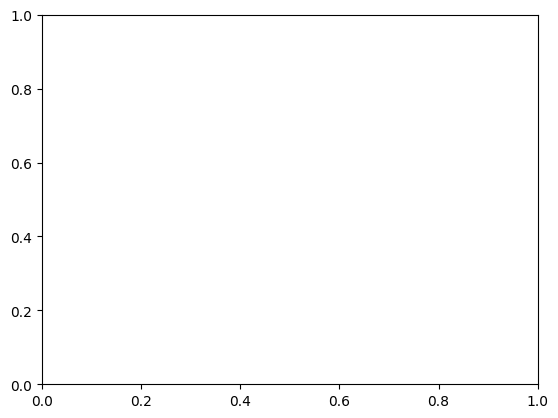

In [9]:
# TODO: Set the simulation time and current input
T_total = 500 # ms
t = np.linspace(0, T_total, T_total+1)

# Set external current amplitudes
I_current_amplitude = [0, 6, 10.7, 20] # microA/cm^2

t_current_start = 50 # input current pulse will start at this time
t_current_end   = [2, 20] # input current pulse will end at this time

# Set the initial values for V, m, n, h
initial = [-63, 0.0530, 0.31777, 0.5961]

# initialize empty array
Iapp = np.zeros_like(t)

# Solve the differential equation using odeint
# t_idx is the index of t_current_end, t0 is the value
# i.e t_idx = 0,1 and t0 = endpoint1,endpoint2 
for t_idx, t_end in enumerate(t_current_end): 
    V = []
    m = []
    n = []
    h = []
    for i_idx, i0 in enumerate(I_current_amplitude):  # loop over different amplitudes
        Iinput = [i0,t_current_start,t_end]
        # Solve the differential equation using odeint
        
        y = odeint(HHModel, initial, t, args=(Iinput,)) # integrate the values over time
        V.append(y[:,0]) # access all of the values for V
        m.append(y[:,1])
        h.append(y[:,2])
        n.append(y[:,3])

    # m represents the activation of the sodium (Na+) channels.
    # n represents the activation of the potassium (K+) channels.
    # h represents the inactivation of the sodium (Na+) channels.
    
        # This is to visualize the stimulus
        for i in range(T_total):
            if (i>= t_current_start) and (i<=t_current_end[t_idx]):
                Iapp[i] = I_current_amplitude[i_idx]
            else:
                Iapp[i] = 0

        # TODO: Plot V(t)
        plt.figure()
        plt.plot(t, V)
        
        #TODO: Overlay with the stimulus
        plt.plot(t, Iapp)

        plt.ylabel('Voltage (mV)', fontsize=15)
        plt.xlabel('Time t (ms)', fontsize=15)
        plt.title('Input Current = {} (\u00B5A/cm\u00B2)'.format(i0), fontweight='bold', fontsize=14)

    

        plt.show()



## 1.1: Spike train generation
### 1.1(b) Quantitative Analysis of the threshold

#### -Simulate the Hodgkin-Huxley Model over 2ms. Use initial conditions of 

\begin{align}
V & = -63\\
m & = 0.0530\\
n & = 0.3177\\
h & = 0.5961 
\end{align}

#### What is the minimal current input that will elicit a spike? For the largest input current that *does not* elicit a spike, what is the maximal membrane potential reached? This will be your best estimate of the threshold
#### -BONUS: repeat the above for a wider input current (larger stimulus duration). Explain why the threshold is sensitive to the input pulse 

In [ ]:
# TODO: Set the simulation time and current input
T_total = 500 # ms
t = np.linspace(0, T_total, T_total+1)

# TO DO: Find minimal current that will elicit a spike 
I_current =  # microA/cm^2


# TODO: Set the initial values for V, m, n, h
initial = [..., ..., ..., ...]

t_current_start = 50 # input current pulse will start at this time
t_current_end   = ... # input current pulse will end at this time

# Solve the differential equation using odeint
t = np.linspace(0, T_total, 10000)


Iinput = [I_current,t_current_start,t_current_end]
y = odeint(HHModel, initial, t, args=(Iinput,)) # integrate the values over time
V = (y[:,0]) # access all of the values for V
m = (y[:,1])
h = (y[:,2])
n = (y[:,3])

# This is to visualize the stimulus
for i in range(T_total):
    if (i>= t_current_start) and (i<=t_current_end[t_idx]):
        Iapp[i] = I_current_amplitude[i_idx]
    else:
        Iapp[i] = 0


# TODO: Plot V(t)
plt.figure()
plt.plot(...,...)
plt.axhline(y=0, color='gray', linestyle='--')

#TODO: Overlay with the stimulus
plt.plot(...,...)

plt.ylabel('Voltage (mV)', fontsize=15)
plt.xlabel('Time t (ms)', fontsize=15)
plt.title('Input Current = {} (\u00B5A/cm\u00B2)'.format(I_current), fontweight='bold', fontsize=14)

plt.show()


print("The maximal membrane potential reached")
print(np.max(V))

## 1.1: Spike train generation
### 1.1(c) Quantitative Analysis of the amplitude

#### -Simulate the Hodgkin-Huxley Model over 500ms. Use initial conditions of 

\begin{align}
V & = -63\\
m & = 0.0530\\
n & = 0.3177\\
h & = 0.5961 
\end{align}

#### Now current will be injected throughout the simulation. Find the minimal current that will generate a sustained spike train. Describe the shape of the action potential.

In [ ]:
# TODO: Set the simulation time and current input
T_total = 500 # ms
t = np.linspace(0, T_total, T_total+1)


# TO DO: Find minimal current that will generate a sustained spike train
I_current =  # microA/cm^2
t_current_start = 0 # input current pulse will start at this time
t_current_end  = T_total # input current pulse will end at this time

# TODO: Set the initial values for V, m, n, h
initial = [..., ..., ..., ...]


# Solve the differential equation using odeint


Iinput = [I_current,t_current_start,t_current_end]
y = odeint(HHModel, initial, t, args=(Iinput,)) # integrate the values over time
V = (y[:,0]) # access all of the values for V
m = (y[:,1])
h = (y[:,2])
n = (y[:,3])



# TODO: Plot V(t)
plt.figure()
plt.plot(...,...)
plt.axhline(y=0, color='gray', linestyle='--')


plt.ylabel('Voltage (mV)', fontsize=15)
plt.xlabel('Time t (ms)', fontsize=15)
plt.title('Input Current = {} (\u00B5A/cm\u00B2)'.format(I_current), fontweight='bold', fontsize=14)

plt.show()

## 1.2: Firing rate vs Current
####  - Using a constant input (10) and T_total = 500, count the number of spikes in a window of fixed size.
        (Hint: you can use the find_peaks() function from scipy.signal to find when the model neuron spikes.
        Docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)
#### - Plot the "F-I curve" (the firing frequency as a function of the input current). 
#### - In words, can "HH neuron" be driven at an arbitrarily high frequency?


In [ ]:
#TODO: Set T_total
T_total = 500 # ms
t = np.linspace(0, T_total, 10000)


# TO DO: Find minimal current that will generate a sustained spike train
I_current =  # microA/cm^2 
t_current_start = 0 # input current pulse will start at this time
t_current_end   = T_total # input current pulse will end at this time


# TODO: Set the initial values for V, m, n, h
initial = [..., ..., ..., ...]


# Solve the differential equation using odeint
t = np.linspace(0, T_total, 10000)

Iinput = [I_current,t_current_start,t_current_end]
y = odeint(HHModel, initial, t, args=(Iinput,)) # integrate the values over time
V = (y[:,0]) # access all of the values for V
m = (y[:,1])
h = (y[:,2])
n = (y[:,3])



plt.plot(t,V)
#TODO: find_peaks
peaks, _ = find_peaks(..., ...) #use a height of 10. Play around with height and see what happens when you change this threshold
num_peaks = len(peaks)



plt.plot(t[peaks], V[peaks], "x", label=f"{num_peaks} peaks above 10 mV")
plt.legend()
plt.ylabel('Voltage (mV)', fontsize=15) 
plt.xlabel('Time t (ms)', fontsize=15) 
plt.show()


# Counting the number of peaks
print('Number of peaks:', num_peaks)


In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Set a range of current inputs
I_current = np.arange(1, 60, 3)
t_current_start = 0 # input current pulse will start at this time
t_current_end   = T_total # input current pulse will end at this time

# Preallocate a vector for storing the spike counts and peak amplitudes
N_spikes = np.zeros(len(I_current))

# TO DO: Set the initial values for V, m, n, h
initial = [..., ..., ..., ...]


T = 500

t = np.linspace(0, T, 10000)

for i in range(len(I_current)):
    Iinput = [I_current[i],t_current_start,t_current_end]
    sol = odeint(HHModel, initial, t, args=(Iinput,))
    V = sol[:,0]
    peaks, _ = find_peaks(..., ...) # Play around with height and see what happens when you change this threshold
    
    # Count the number of spikes
    N_spikes[i] = len(peaks)




In [ ]:
# TODO: plot the f-I curve
# note, divide N_spikes by T *1000
plt.plot(...,..., '-o')
plt.xlabel('Applied Current (μA/cm$^2$)')
plt.ylabel('Avg # of spikes')
plt.title("F-I curve")
plt.show()

## 1.3: Correlated Variables
####  - Use a current value of 10.  For each pair of variables V, m, n, h (6 pairs), plot one variable as a function of the other. 
#### -Identify pairs that are most strongly correlated. 
#### -How can this identification help in reducing the neuron model’s dimension? 
#### -Does the choice of current amplitude affect which pairs of variables are most correlated?

In [ ]:
# Rerun the simulation for an amplitude above the spiking threshold

# Set the simulation time and current input
T = 500  # ms

# TODO: set amplitude above the spiking threshold. Does this choice affect correlation?
I_current =  # microA/cm^2
t_current_start = 0 # input current pulse will start at this time
t_current_end   = T_total # input current pulse will end at this time


# TODO: Set the initial values for V, m, n, h
initial = 


# Solve the differential equation using odeint
t = np.linspace(0, T, 10000)
Iinput = [I_current,t_current_start,t_current_end]
y = odeint(HHModel, initial, t, args=(Iinput,))


# Get the V(t), m(t), n(t), h(t)
V = y[:,0]
m = y[:,1] 
n = y[:,2]
h = y[:,3]

In [ ]:
# TODO: Provided below is a SAMPLE of how to plot 6 plots at once. Run this code block to see the example
# Change the code to plot V-m, V-n, V-h, n-m, n-h, h-m

x = np.linspace(0, 2*np.pi, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x)
y4 = np.exp(-x)
y5 = np.sqrt(x)
y6 = np.log(x)

# Create a figure with 6 subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# Plot data on each subplot
axes[0, 0].plot(x, y1)
axes[0, 0].set_title('sin(x)')

axes[0, 1].plot(x, y2)
axes[0, 1].set_title('cos(x)')

axes[0, 2].plot(x, y3)
axes[0, 2].set_title('tan(x)')

axes[1, 0].plot(x, y4)
axes[1, 0].set_title('exp(-x)')

axes[1, 1].plot(x, y5)
axes[1, 1].set_title('sqrt(x)')

axes[1, 2].plot(x, y6)
axes[1, 2].set_title('log(x)')

# Add global labels and title
fig.suptitle('Six Subplots')
fig.text(0.5, 0.04, 'x', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'y', va='center', rotation='vertical', fontsize=12)

# Adjust spacing and layout
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Show the plot
plt.show()


In [ ]:
# Identify pairs that are most strongly correlated

# Put each variable in a dataframe
data = {'V': V, 'm': m, 'n': n, 'h': h}

# Create a dataframe using the dictionary
df = pd.DataFrame(data)

# Print the dataframe
print(df)

In [ ]:
# TODO: calculate the correlation matrix
corr_matrix = 

# Print the correlation matrix
print(corr_matrix)